# Investigation of anomalous undervote rate in Lt. Gov contest

## P.B. Stark and Kellie Ottoboni

If, within each piece of geography (county or precinct), each undervote 
in a statewide contest were equally likely to be in any of the other statewide contests (Lt. Gov, SoS, Attorney General, Commissioner of Agriculture, Commissioner of Insurance, Secretary of Labor, Superintendent of Schools), what is the chance that the highest undervote rate would be as high or higher than observed for the Lt. Gov. contest?

Randomization model: within each piece of geography, each undervote is equally likely to be in any of the 7 statewide contests (not counting Governor), independently across undervotes and across geography.

Test statistic: largest undervote rate across the 7 contests.

Test for the entire election, and separately for Polling-Place and Vote-By-Mail.

Data flow:

+ for each piece of geography, determine the total number of ballots cast from <ElectionVoterTurnout />
    - subtract total votes in each of the 7 contests from the number of ballots cast to get the number of undervotes in each of the contests in each piece of geography
    - pool the 7 contests to get the total number of undervotes for that piece of geography
    - aggregate over geography to get the total number of undervotes in each of the 7 contests, and the maximum undervote rate
+ Test
    - in each piece of geography, randomly assign each undervote a label of 1--7
    - aggregate across geography
    - record maximum undervote rate across the 7 contests

In [1]:
%matplotlib inline
import math
import numpy as np
import scipy as sp
import scipy.optimize
from scipy.stats import hypergeom, binom, norm
from scipy import special
from cryptorandom.cryptorandom import SHA256
from cryptorandom import sample
from permute.utils import binom_conf_interval
import matplotlib.pyplot as plt
import pandas as pd
from lxml import etree
import csv

reps = 100

In [2]:
statewide_contests = np.array(["Lieutenant Governor", "Secretary Of State", \
                               "Attorney General", "Commissioner Of Agriculture", \
                               "Commissioner Of Insurance", "State School Superintendent", "Commissioner Of Labor"])

votes = pd.read_csv('../../Data/undervotes_by_county.csv')
votes.head()

,County,Vote type,Total ballots,Contest,Ballots cast,Undervotes
0,Appling,Absentee by Mail,530,Lieutenant Governor,523,7
1,Appling,Advance in Person,3298,Lieutenant Governor,3092,206
2,Appling,Election Day,2978,Lieutenant Governor,2768,210
3,Appling,Provisional,3,Lieutenant Governor,3,0
4,Atkinson,Absentee by Mail,88,Lieutenant Governor,88,0


In [3]:
total_votes = votes.groupby(["County", "Contest"]).agg(np.sum)
total_votes = total_votes.reset_index()
total_votes.head()

,County,Contest,Total ballots,Ballots cast,Undervotes
0,Appling,Attorney General,6809,6562,247
1,Appling,Commissioner Of Agriculture,6809,6577,232
2,Appling,Commissioner Of Insurance,6809,6607,202
3,Appling,Commissioner Of Labor,6809,6592,217
4,Appling,Lieutenant Governor,6809,6386,423


## Calculate the number of undervotes in each county

In [4]:
def calculate_undervotes_by_geography(df, geography_name):
    geog_undervotes = df.groupby([geography_name]).agg({'Undervotes' : 'sum',
                                                     'Total ballots' : lambda x: x.iloc[0]})
    geog_undervotes = geog_undervotes.reset_index()
    return geog_undervotes

In [5]:
undervote_totals = calculate_undervotes_by_geography(total_votes, "County")

## Test statistics

In [6]:
def calculate_max_undervote_rate(df):
    statewide_votes = df.groupby(["Contest"]).agg(np.sum)
    rates = statewide_votes["Undervotes"]/statewide_votes["Total ballots"]
    return np.max(rates)


def calculate_max_reversal2(undervotes):
    return np.max(np.diff(np.flip(undervotes)))

def calculate_max_reversal(undervotes):
    maxu = 0
    u = len(undervotes)
    for i in range(u): 
        for j in range(i+1, u): 
            maxu = np.max([maxu, undervotes[i]-undervotes[j]])
    return maxu


def calculate_correlation(undervotes):
    return np.corrcoef(undervotes, np.arange(1, len(undervotes)+1))[0,1]

## Function to randomly allocate undervotes and compute a statistic

In [7]:
def permute_undervotes(total_votes_df, geography_name="County", prng=np.random):
    statewide_contests = np.array(["Lieutenant Governor", "Secretary Of State", \
                                   "Attorney General", "Commissioner Of Agriculture", \
                                   "Commissioner Of Insurance", "State School Superintendent", "Commissioner Of Labor"])
    undervote_totals = calculate_undervotes_by_geography(total_votes_df, "County")
    
    permuted_undervotes = np.zeros(7)
    
    # Loop over geographic units
    for index, row in undervote_totals.iterrows():
        N = row["Total ballots"]
        slots = np.repeat(np.arange(7), N)
        
        # in each geog. unit, randomly allocate the U undervotes to each of 7 contests
        random_contests = sample.random_sample(slots, row["Undervotes"], replace=False, prng=prng)
        for i in range(len(statewide_contests)):
            tot = np.sum(random_contests == i)
            permuted_undervotes[i] += tot

    # Calculate the largest reversal U_i - U_j, for i < j
    return calculate_max_reversal(permuted_undervotes)

## Initialize the pseudo-random number generator

In [8]:
#seed = '2018CV313418 3463593937'  # case caption number [space] 10 rolls of 10-sided dice
#prng = SHA256(seed)

seed = 1234
prng = np.random
np.random.seed(seed)

# Results for the entire election

In [9]:
undervotes_observed = [np.sum(votes.loc[votes["Contest"]==statewide_contests[i], "Undervotes"]) \
                       for i in range(7)]
for i in range(7):
    print(statewide_contests[i], undervotes_observed[i])
tst = calculate_max_reversal(undervotes_observed)
print("Max reversal:", tst)

Lieutenant Governor 159038
Secretary Of State 55748
Attorney General 76972
Commissioner Of Agriculture 95862
Commissioner Of Insurance 77717
State School Superintendent 76878
Commissioner Of Labor 89892
Max reversal: 103290


In [10]:
perm_distribution = [permute_undervotes(total_votes, geography_name="County", prng=prng) for i in range(reps)]

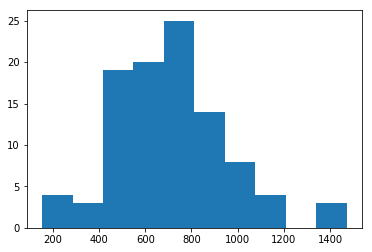

0.009900990099009901

In [11]:
plt.hist(perm_distribution)
plt.show()

(1+np.sum(perm_distribution >= tst))/(reps+1)

# Results for the absentee votes

In [12]:
absentee_votes = votes[votes["Vote type"]=="Absentee by Mail"]
absentee_votes = absentee_votes.copy()

In [13]:
undervotes_observed_abs = [np.sum(absentee_votes.loc[absentee_votes["Contest"]==statewide_contests[i], "Undervotes"]) \
                       for i in range(7)]
for i in range(7):
    print(statewide_contests[i], undervotes_observed_abs[i])
tst_abs = calculate_max_reversal(undervotes_observed_abs)
print("Max reversal:", tst_abs)

Lieutenant Governor 2244
Secretary Of State 3066
Attorney General 3788
Commissioner Of Agriculture 4543
Commissioner Of Insurance 3758
State School Superintendent 4735
Commissioner Of Labor 5523
Max reversal: 785


In [14]:
perm_distribution_abs = [permute_undervotes(absentee_votes, geography_name="County", prng=prng) for i in range(reps)]

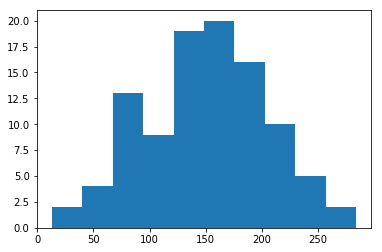

0.009900990099009901

In [15]:
plt.hist(perm_distribution_abs)
plt.show()

(1+np.sum(perm_distribution_abs >= tst_abs))/(reps+1)

# Results for the election day votes

In [16]:
electionday_votes = votes[votes["Vote type"]=="Election Day"]
electionday_votes = electionday_votes.copy()

In [17]:
undervotes_observed_ed = [np.sum(electionday_votes.loc[electionday_votes["Contest"]==statewide_contests[i], "Undervotes"]) \
                       for i in range(7)]
for i in range(7):
    print(statewide_contests[i], undervotes_observed_ed[i])
tst_ed = calculate_max_reversal(undervotes_observed_ed)
print("Max reversal:", tst_ed)

Lieutenant Governor 82293
Secretary Of State 27531
Attorney General 39451
Commissioner Of Agriculture 50152
Commissioner Of Insurance 41017
State School Superintendent 40077
Commissioner Of Labor 47062
Max reversal: 54762


In [18]:
perm_distribution_ed = [permute_undervotes(electionday_votes, geography_name="County", prng=prng) for i in range(reps)]

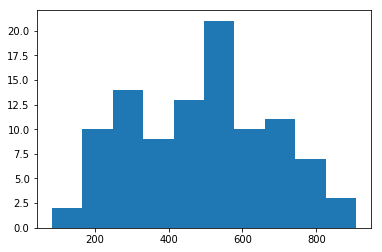

0.009900990099009901

In [19]:
plt.hist(perm_distribution_ed)
plt.show()

(1+np.sum(perm_distribution_ed >= tst_ed))/(reps+1)

# Repeat everything with the 2014 data

In [20]:
votes_2014 = pd.read_csv('../../Data/undervotes_by_county_2014.csv')
votes_2014.head()

,County,Vote type,Total ballots,Contest,Ballots cast,Undervotes
0,Appling,Absentee by Mail,306,Lieutenant Governor,302,4
1,Appling,Advance in Person,976,Lieutenant Governor,970,6
2,Appling,Election Day,3122,Lieutenant Governor,3073,49
3,Appling,Provisional,4,Lieutenant Governor,4,0
4,Atkinson,Absentee by Mail,68,Lieutenant Governor,66,2


In [21]:
total_votes_2014 = votes_2014.groupby(["County", "Contest"]).agg(np.sum)
total_votes_2014 = total_votes_2014.reset_index()
total_votes_2014.head()

,County,Contest,Total ballots,Ballots cast,Undervotes
0,Appling,Attorney General,4408,4362,46
1,Appling,Commissioner Of Agriculture,4408,4373,35
2,Appling,Commissioner Of Insurance,4408,4341,67
3,Appling,Commissioner Of Labor,4408,4366,42
4,Appling,Lieutenant Governor,4408,4349,59


In [22]:
undervote_totals_2014 = calculate_undervotes_by_geography(total_votes_2014, "County")

## Results for the entire 2014 election

In [23]:
undervotes_observed_2014 = [np.sum(votes_2014.loc[votes["Contest"]==statewide_contests[i], "Undervotes"]) \
                       for i in range(7)]
for i in range(7):
    print(statewide_contests[i], undervotes_observed_2014[i])
tst_2014 = calculate_max_reversal(undervotes_observed_2014)
print("Max reversal:", tst_2014)

Lieutenant Governor 23228
Secretary Of State 24635
Attorney General 28035
Commissioner Of Agriculture 42912
Commissioner Of Insurance 32429
State School Superintendent 28399
Commissioner Of Labor 44730
Max reversal: 14513


In [24]:
perm_distribution_2014 = [permute_undervotes(total_votes_2014, geography_name="County", prng=prng) for i in range(reps)]

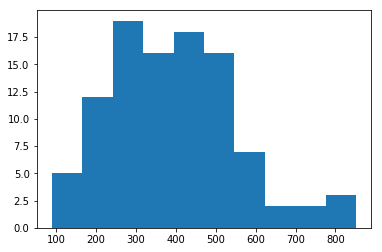

0.009900990099009901

In [25]:
plt.hist(perm_distribution_2014)
plt.show()

(1+np.sum(perm_distribution_2014 >= tst_2014))/(reps+1)

## Results for the 2014 absentee votes

In [26]:
absentee_votes_2014 = votes_2014[votes_2014["Vote type"]=="Absentee by Mail"]
absentee_votes_2014 = absentee_votes_2014.copy()

In [27]:
undervotes_observed_abs_2014 = [np.sum(absentee_votes_2014.loc[absentee_votes_2014["Contest"]==statewide_contests[i], \
                                                               "Undervotes"]) for i in range(7)]
for i in range(7):
    print(statewide_contests[i], undervotes_observed_abs_2014[i])
tst_abs_2014 = calculate_max_reversal(undervotes_observed_abs_2014)
print("Max reversal:", tst_abs_2014)

Lieutenant Governor 1283
Secretary Of State 1855
Attorney General 2158
Commissioner Of Agriculture 2751
Commissioner Of Insurance 2537
State School Superintendent 2554
Commissioner Of Labor 3226
Max reversal: 214


In [28]:
perm_distribution_abs_2014 = [permute_undervotes(absentee_votes_2014, geography_name="County", prng=prng) \
                              for i in range(reps)]

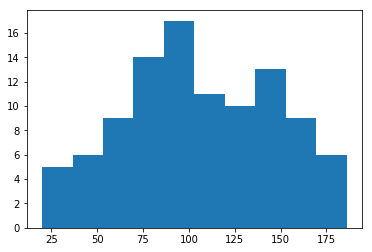

0.009900990099009901

In [29]:
plt.hist(perm_distribution_abs_2014)
plt.show()

(1+np.sum(perm_distribution_abs_2014 >= tst_abs_2014))/(reps+1)

## Results for the 2014 election day votes

In [30]:
electionday_votes_2014 = votes_2014[votes_2014["Vote type"]=="Election Day"]
electionday_votes_2014 = electionday_votes_2014.copy()

In [31]:
undervotes_observed_ed_2014 = [np.sum(electionday_votes_2014.loc[electionday_votes_2014["Contest"]==statewide_contests[i], \
                                                                 "Undervotes"]) for i in range(7)]
for i in range(7):
    print(statewide_contests[i], undervotes_observed_ed_2014[i])
tst_ed_2014 = calculate_max_reversal(undervotes_observed_ed_2014)
print("Max reversal:", tst_ed_2014)

Lieutenant Governor 15106
Secretary Of State 16374
Attorney General 18324
Commissioner Of Agriculture 26828
Commissioner Of Insurance 21500
State School Superintendent 18787
Commissioner Of Labor 30206
Max reversal: 8041


In [32]:
perm_distribution_ed_2014 = [permute_undervotes(electionday_votes_2014, geography_name="County", prng=prng) \
                             for i in range(reps)]

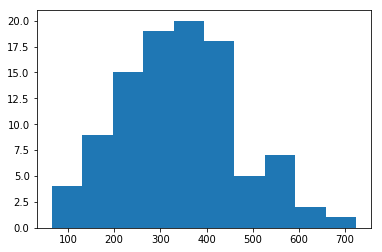

0.009900990099009901

In [33]:
plt.hist(perm_distribution_ed_2014)
plt.show()

(1+np.sum(perm_distribution_ed_2014 >= tst_ed_2014))/(reps+1)